<a href="https://colab.research.google.com/github/shellerbrand/machine-learning-for-artistic-style/blob/master/machine_learning_artistic_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neue Werke alter Meister - Transfer von Bildstilen mit Neuronalen Netzen

Das Erkennen von Objekten ist eine Aufgabe, die der Mensch ausgezeichnet beherrscht. Auch Computer sind inzwischen mit Hilfe von künstlichen neuronalen Netzen in der Lage, diese Aufgabe in spezifischen Fällen sehr zuverlässig zu erledigen.

Besonders leistungsfähig is hierbei die Klasse der [Convolutional Neural Networks](https://de.wikipedia.org/wiki/Convolutional_Neural_Network) (ConvNets). Diese Netze bestehen aus einer Folge von Schichten. Die Ausgänge der ersten Schichten entsprechen dabei der Bildzusammensetzung auf Pixel-Ebene, wohingegen die Ausgänge späterer Schichten immer großflächigere Zusammenhänge beschreiben.

Ein Forschungsteam aus Tübingen [hat gezeigt](https://arxiv.org/abs/1508.06576) , dass sich der Stil eines Gemäldes gut über die Aktivierung der früheren Schichten eines ConvNets beschreiben lässt. Sie haben außerdem gezeigt, wie man ein Bild erzeugen kann, das dem Inhalt eines bestimmten Bildes (__Inhaltsbild__) und dem Stil eines anderen Bildes (__Stilbild__) entspricht.

<img src="https://github.com/shellerbrand/machine-learning-for-artistic-style/raw/master/resources/vgg-convnet-inhalt-und-stil.jpg" alt="Convolutional Neural Network" width="700"/>

__Mit diesem Notebook kann man mit diesem neuralen Stil-Transfer experimentieren.__

Das Beispiel wurde im Rahmen des Blockseminars [Lernen, wie Maschinen lernen](https://www.mzl.uni-muenchen.de/lehramtpro/programm/Lernen_-wie-Maschinen-lernen/index.html) erstellt. Wir benutzen dabei unter anderem modifizierten Code aus dem Repository des Projekts [Google Magenta](https://github.com/tensorflow/magenta), der dem Verfahren von [Ghiasi et al.](https://arxiv.org/abs/1705.06830) entspricht.


---

## Vorarbeiten

Diese Schritte müssen nur einmal ausgeführt werden.

In [2]:
#@title Die benötigten Modelle und den Stil-Transfer Code in die Umgebung kopieren.
!curl https://raw.githubusercontent.com/shellerbrand/machine-learning-for-artistic-style/master/dist/stylization-lib.tar.gz -o image-stylization-lib.tar.gz

import sys
IN_COLAB = 'google.colab' in sys.modules
# Ensure the required version of scipy is installed in colab
if IN_COLAB:
    !pip install scipy==1.1.0

# The Model can be downloaded as per Google Magenta project
!curl https://storage.googleapis.com/download.magenta.tensorflow.org/models/arbitrary_style_transfer.tar.gz -o image-stylization-checkpoint.tar.gz

# Unpack
!tar -zxvf image-stylization-lib.tar.gz
!tar -zxvf image-stylization-checkpoint.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48902  100 48902    0     0   237k      0 --:--:-- --:--:-- --:--:--  237k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  606M  100  606M    0     0  10.0M      0  0:01:00  0:01:00 --:--:-- 10.3M9519k      0  0:01:05  0:00:05  0:01:00  9.9M2k      0  0:01:04  0:00:06  0:00:58 9990k29k    0  0:01:02  0:00:11  0:00:51 10.0M0  10.0M      0  0:01:00  0:00:50  0:00:10 10.2M
lib/
lib/image_utils.py
lib/vgg.py
lib/arbitrary_image_stylization_build_model.py
lib/arbitrary_image_stylization_train.py
lib/imagenet_data.py
lib/__init__.py
lib/__pycache__/
lib/__pycache__/arbitrary_image_stylization_with_weights_func.cpython-36.pyc
lib/__pycache__/imagenet_data.cpython-36.pyc
lib/__pycache__/image_utils.cpython-36.pyc
lib/__py

In [2]:
#@title Hilfs-Funktionen laden (werden für Laden und Anzeigen der Bilder benötigt)

# 
# Funktionen um Bilder zu laden vom Image-Upload Tool
#

print('Laden von Funktionen zum Laden der Stil und Inhaltsbilder.')

import requests
import os
import shutil

HOST = 'https://imageupload.hellerbit.com'
API_KEY = 'bce8a814f0b3882ac6f2810464128b42dbfee105e1ba84311a77b3f4'
DIR = './tmp/'
EXP_CONTENT = '2_inhalt'
EXP_STYLE = '2_stil'
OUTDIR = './output/'


if not os.path.isdir(DIR):
    print('Making the directory: {}'.format(DIR))
    os.makedirs(DIR)

def clear_output():
    if os.path.isdir(OUTDIR):
        shutil.rmtree(OUTDIR)
        os.mkdir(OUTDIR)

def clear_experiment(experiment_id):
    expdir = os.path.join(DIR, experiment_id)
    if os.path.isdir(expdir):
        shutil.rmtree(expdir)

def download_experiment_images(experiment_id):
    url = ''.join([HOST, '/api/{}/all.txt'.format(experiment_id)])
    headers = {'APIKEY': API_KEY}
    resp = requests.get(url, headers=headers)

    print(resp.text)
    files = resp.text.split('\n')
    # Make the directory for the experiment
    expdir = os.path.join(DIR, experiment_id)
    if not os.path.isdir(expdir):
            os.makedirs(expdir)

    for line in files:
        print("Loading this file: {}".format(line))
        url = ''.join([HOST, '/api/{}/{}'.format(experiment_id, line)])
        path = os.path.join(expdir, line)
        print("\t from URL {}".format(url))
        r = requests.get(url, stream=True, headers=headers)
        if r.status_code == 200:
            with open(path, 'wb') as f:
                for chunk in r:
                    f.write(chunk)
                    
#
# Funktionen zur Anzeige von Bildern laden
#

print('Laden von Funktionen zum Anzeigen von Bildern.')
# Configuration of matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

# python image library, numpy etc.
import numpy as np
from PIL import Image
import time
import functools

from tensorflow.python.keras.preprocessing import image as kp_image

# Helper function for loading images from a path
def load_img(path_to_img):
  max_dim = 1024
  img = Image.open(path_to_img)
  long = max(img.size)
  scale = max_dim/long
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), 
                   Image.ANTIALIAS)
  
  img = kp_image.img_to_array(img)
  
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

# Helper function for showing an image object (as per PIL)
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.axis('off')
  plt.imshow(out)
  

print('Erledigt.')

Laden von Funktionen zum Laden der Stil und Inhaltsbilder.
Laden von Funktionen zum Anzeigen von Bildern.
Erledigt.


---


## Bilder Hochladen

Im Folgenden werden die Bilder importiert, die für den Stil-Transfer verwendet werden sollen. Ihr könnt anpassen, welche Bilder als Vorlage für den Stil dienen sollen. Diese __Stilbilder__  könnt Ihr z.B. mit dem Handy auf folgendem Link hochladen:

https://imageupload.hellerbit.com/images/2_stil/

Die __Inhaltsbilder__, auf die der Stil angewandt wird, können auf 

https://imageupload.hellerbit.com/images/2_inhalt/

hochgeladen werden.


<img src="https://github.com/shellerbrand/machine-learning-for-artistic-style/raw/master/resources/iphone_upload_tool_list.png" width="300" style="float:right;">

Nun bitte den Schlüssel eingeben, mit dem die Bilder geladen werden. Wenn  Bilder hochgeladen wurden, dann sollte man diese Zelle laufen lassen.

In [3]:
#@title Den Schlüssel zum Download der Bilder hier eingeben
API_KEY = "3c7f5f9a4d227972f0989cb7c1be7ad0835990d03f84ed8efbae839a" #@param {type:"string"}
clear_experiment(EXP_CONTENT)
clear_experiment(EXP_STYLE)
clear_output()
download_experiment_images(EXP_CONTENT)
download_experiment_images(EXP_STYLE)

20181112_114430.jpg
image-3ZKSUR83YE.jpg
Loading this file: 20181112_114430.jpg
	 from URL https://imageupload.hellerbit.com/api/2_inhalt/20181112_114430.jpg
Loading this file: image-3ZKSUR83YE.jpg
	 from URL https://imageupload.hellerbit.com/api/2_inhalt/image-3ZKSUR83YE.jpg
Vassily_Kandinsky_1908_Murnau_Dorfstrasse.jpg
Loading this file: Vassily_Kandinsky_1908_Murnau_Dorfstrasse.jpg
	 from URL https://imageupload.hellerbit.com/api/2_stil/Vassily_Kandinsky_1908_Murnau_Dorfstrasse.jpg


## Bildstile Übertragen

Jetzt können die Bildstile übertragen werden. 

Für jedes __Stilbild__ wird zunächst ein Vektor S ermittelt, der den Stil des Bildes beschreibt. Im Anschluss wird dieser Vektor an das Stiltransfer-Netz übergeben, das diesen Stil dem __Inhaltsbild__ aufprägt.

<img src="https://github.com/shellerbrand/machine-learning-for-artistic-style/raw/master/resources/netze-fuer-analyse-und-transfer.jpg" alt="Convolutional Neural Network" width="700"/>

Die Netze, die in unserem Beispiel benutzt werden, wurden von Google im Projekt Magenta bereits vortrainiert. Man kann sich das so vorstellen, dass das Netz für die Stil-Analyse bereits zehntausende Bilder angesehen hat. Deshalb kann es den Stil auch für Bilder beschreiben, die es zuvor noch nicht gesehen hat. In ähnlicher Weise wurde das Stil-Transfer Netzwerk mit sehr vielen Bildern dafür trainiert, einen Stil auf ein Inhaltsbild zu übertragen.

Die beiden vortrainierten Netze werden nun für alle Kombinationen der __Stil-__ und __Inhaltsbilder__, die im vorherigen Schritt hochgeladen wurden, angewendet.


In [4]:
#@title Umwandlung starten
from lib.arbitrary_image_stylization_with_weights_func import arbitrary_stylization_with_weights, StyleTransferConfig
# from lib.arbitrary_image_stylization_with_weights import main as dostyle
import tensorflow as tf

c = StyleTransferConfig()
c.content_images_paths = os.path.join(DIR,'2_inhalt/*')
c.output_dir = OUTDIR
c.style_images_paths = os.path.join(DIR,'2_stil/*')
c.checkpoint = './arbitrary_style_transfer/model.ckpt'
c.image_size = 512
c.style_image_size = 256
print(c)

with tf.device('/gpu:0'):
  arbitrary_stylization_with_weights(c)

print("\nErledigt.")

checkpoint: ./arbitrary_style_transfer/model.ckpt
style_images_paths: ./tmp/2_stil/*
content_images_paths: ./tmp/2_inhalt/*
output_dir: ./output/
image_size: 512
content_square_crop: False
style_image_size: 256
style_square_crop: False
maximum_styles_to_evaluate: 10
interpolation_weights: [1.0]

INFO:tensorflow:loading latest checkpoint file: ./arbitrary_style_transfer/model.ckpt
INFO:tensorflow:Restoring parameters from ./arbitrary_style_transfer/model.ckpt
Getting the list of input style images
['./tmp/2_stil/Vassily_Kandinsky_1908_Murnau_Dorfstrasse.jpg']
Getting the list of content images
['./tmp/2_inhalt/image-3ZKSUR83YE.jpg', './tmp/2_inhalt/20181112_114430.jpg']
INFO:tensorflow:Stylizing (0) image-3ZKSUR83YE with (0) Vassily_Kandinsky_1908_Murnau_Dorfstrasse
INFO:tensorflow:Stylizing (1) 20181112_114430 with (0) Vassily_Kandinsky_1908_Murnau_Dorfstrasse

Erledigt.


## Bilder ansehen

Nachdem der Stiltransfer ohne Fehler durchgelaufen ist, könnt ihr Euch hier die Bilder ansehen.

Die Bilder, die im Stil gewandelt werden


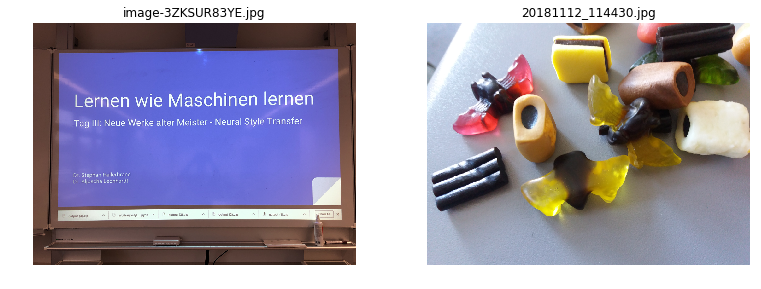

In [5]:
#@title Inhaltsbilder ansehen
# Get all content images
cols = 3
basewidth=20
cfiles = os.listdir(path=os.path.join(DIR, EXP_CONTENT))
#print("{},{}".format(basewidth,len(files)/cols*basewidth))
plt.figure(num=1, figsize=(basewidth,len(cfiles)/(cols*cols)*basewidth))
pind = 1
for fi in cfiles:
    path = os.path.join(DIR, EXP_CONTENT, fi)
    # print(path)
    im = load_img(path_to_img=path).astype('uint8')    
    plt.subplot(np.ceil(len(cfiles)/cols),cols,pind)
    imshow(im,title=fi)
    pind = pind + 1
    
print("Die Bilder, die im Stil gewandelt werden")

Die Bilder, deren Stil angewandt wird


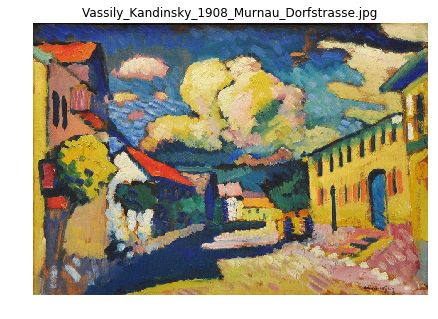

In [6]:
#@title Stilbilder ansehen
# Get all style images
basewidth=20
sfiles = os.listdir(path=os.path.join(DIR, EXP_STYLE))
cols = len(sfiles)+1
#print("{},{}".format(basewidth,len(files)/cols*basewidth))
plt.figure(num=1, figsize=(basewidth,len(sfiles)/(cols*cols)*basewidth))
plt.axis('off')

pind = 1
sfiles.sort()
for fi in sfiles:
    path = os.path.join(DIR, EXP_STYLE, fi)
    # print(path)
    im = load_img(path_to_img=path).astype('uint8')    
    plt.subplot(np.ceil(len(sfiles)/cols),cols,pind)
    imshow(im,title=fi)
    pind = pind + 1
    
print("Die Bilder, deren Stil angewandt wird")

Die im Stil gewandelten Bilder:


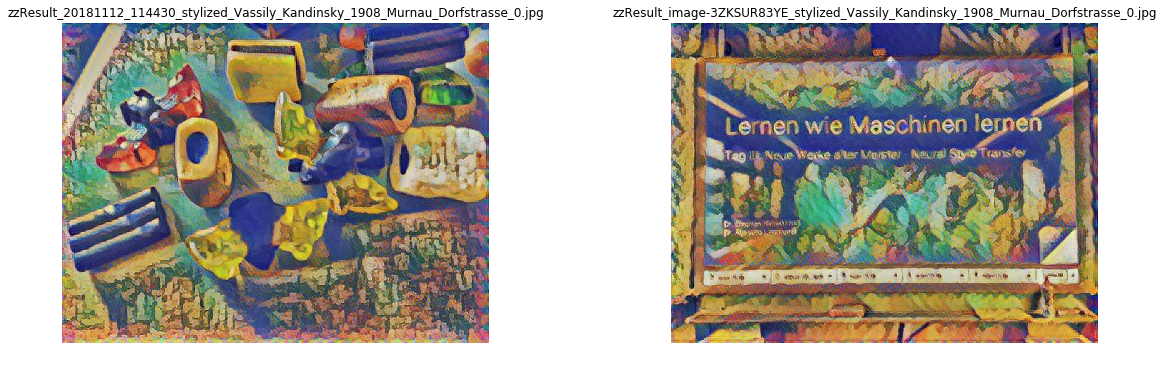

In [7]:
#@title Bilder mit übertragenem Stil ansehen
# Stylized Images
from re import match

cols = 3
basewidth=20
files = os.listdir(path=os.path.join(OUTDIR))
files = [x for x in files if match('^zzResult.*',x)]
#print("{},{}".format(basewidth,len(files)/cols*basewidth))
plt.figure(num=1, figsize=(basewidth,len(cfiles)/(len(sfiles)+1)*basewidth))
pind = 1
files.sort()
for fi in files:
    path = os.path.join(OUTDIR, fi)
    # print(path)
    im = load_img(path_to_img=path).astype('uint8')    
    plt.subplot(len(cfiles)+1,len(sfiles)+1,pind)
    imshow(im,title=fi)
    pind = pind + 1
    
print("Die im Stil gewandelten Bilder:")

In [3]:
#@title Alle Bilder als Zip-File herunterladen (nur Colab)
if IN_COLAB:
    !zip output.zip output/*
    from google.colab import files
    files.download("output.zip")
else:
    print("Not in colab - skipping.")



Not in colab - skipping.


---

## Referenzen

* Gatys, L. et al; A Neural Algorithm of Artistic Style, Sep 2015, [arxiv](https://arxiv.org/abs/1508.06576)
* Google Magenta: Fast Style Transfer for Arbitrary Styles, [Github](https://github.com/tensorflow/magenta/blob/2c3ae9b0dd64b06295e48e2ee5654e3d207035fc/magenta/models/arbitrary_image_stylization/README.md)  
* Ghiasi, G. et al.; 
Exploring the structure of a real-time, arbitrary neural artistic stylization network
Golnaz Ghiasi, Aug 2017, [arxiv](https://arxiv.org/abs/1705.06830)

Der Source-Code für dieses Notebook und das Tool zum Bilder hochladen sind bzw. werden hier veröffentlicht:
https://github.com/shellerbrand/machine-learning-for-artistic-style
